In [2]:
import numpy as np
from PIL import Image
import os
import torchio as tio
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [21]:
from io import BytesIO
import cv2
import ctypes
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor

wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle

# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)

def motion_blur(x, severity=1):
    c = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]

    output = BytesIO()
    x.save(output, format='PNG')
    x = MotionImage(blob=output.getvalue())

    x.motion_blur(radius=c[0], sigma=c[1], angle=np.random.uniform(-45, 45))

    x = cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
                     cv2.IMREAD_UNCHANGED)

    if x.shape != (224, 224):
        return np.clip(x[..., [2, 1, 0]], 0, 255)  # BGR to RGB
    else:  # greyscale to RGB
        return np.clip(np.array([x, x, x]).transpose((1, 2, 0)), 0, 255)

In [22]:
csv_file =  pd.read_csv("test.csv")
image_list = csv_file["id"].values

np.random.seed(0)
for s in range(1, 2):
    for idx in tqdm(range(len(image_list))):
        image_name = image_list[idx]
        image_path = os.path.join("test/clean", image_name+".jpg")
        image_new_path = image_path.replace("clean", f"motion_{s}")
        image = Image.open(image_path)

        image = motion_blur(image, s)
        
        image = Image.fromarray(image)
        image.save(image_new_path)

  0%|          | 0/5067 [00:00<?, ?it/s]

/tmp/ipykernel_3710367/3921746731.py:27: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
100%|██████████| 5067/5067 [11:30<00:00,  7.34it/s]


In [3]:
def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

In [4]:
clean = 14
corrupted = 20 - clean
strength = 3

dict_users = np.load(f"dict_users_noniid_dir1.0_CorruptedNum{corrupted}.npy", allow_pickle=True).item()
csv_file =  pd.read_csv("train.csv")
image_list = csv_file["id"].values

s_idx = np.ones(20) * -1
np.random.seed(0)
for client_id in tqdm(range(20)):
    for idx in dict_users[client_id]:
        image_name = image_list[idx]
        image_path = os.path.join("train/clean", image_name+".png")
        image_new_path = image_path.replace("clean", f"gaussian{strength}_{clean}_{corrupted}_dir1.0")
        image = Image.open(image_path)
        if client_id < clean:
            image = image
            if s_idx[client_id] == -1:
                s_idx[client_id] = 0
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        else:
            image = np.array(image)
            image = gaussian_noise(image, strength).astype("uint8")
            image = Image.fromarray(image)
            if s_idx[client_id] == -1:
                s_idx[client_id] = strength
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        image.save(image_new_path)

  0%|          | 0/20 [00:00<?, ?it/s]

id: 0, s: 0.0


  5%|▌         | 1/20 [00:02<00:48,  2.57s/it]

id: 1, s: 0.0


 10%|█         | 2/20 [00:04<00:35,  2.00s/it]

id: 2, s: 0.0


 15%|█▌        | 3/20 [00:05<00:31,  1.84s/it]

id: 3, s: 0.0


 20%|██        | 4/20 [00:06<00:21,  1.32s/it]

id: 4, s: 0.0


 25%|██▌       | 5/20 [00:08<00:23,  1.58s/it]

id: 5, s: 0.0


 30%|███       | 6/20 [00:09<00:18,  1.34s/it]

id: 6, s: 0.0


 35%|███▌      | 7/20 [00:11<00:19,  1.53s/it]

id: 7, s: 0.0


 40%|████      | 8/20 [00:12<00:19,  1.59s/it]

id: 8, s: 0.0


 45%|████▌     | 9/20 [00:13<00:15,  1.38s/it]

id: 9, s: 0.0


 50%|█████     | 10/20 [00:14<00:12,  1.21s/it]

id: 10, s: 0.0


 55%|█████▌    | 11/20 [00:16<00:12,  1.40s/it]

id: 11, s: 0.0


 60%|██████    | 12/20 [00:17<00:11,  1.41s/it]

id: 12, s: 0.0


 65%|██████▌   | 13/20 [00:20<00:11,  1.65s/it]

id: 13, s: 0.0


 70%|███████   | 14/20 [00:23<00:12,  2.13s/it]

id: 14, s: 3.0


 75%|███████▌  | 15/20 [00:27<00:14,  2.83s/it]

id: 15, s: 3.0


 80%|████████  | 16/20 [00:37<00:20,  5.02s/it]

id: 16, s: 3.0


 85%|████████▌ | 17/20 [00:46<00:17,  5.97s/it]

id: 17, s: 3.0


 90%|█████████ | 18/20 [00:50<00:11,  5.55s/it]

id: 18, s: 3.0


 95%|█████████▌| 19/20 [00:54<00:05,  5.13s/it]

id: 19, s: 3.0


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


In [4]:
clean = 16
corrupted = 20 - clean
strength = 3

dict_users = np.load(f"dict_users_noniid_dir1.0_CorruptedNum{corrupted}.npy", allow_pickle=True).item()
csv_file =  pd.read_csv("train.csv")
image_list = csv_file["id"].values

s_idx = np.ones(20) * -1
np.random.seed(0)
for client_id in tqdm(range(20)):
    for idx in dict_users[client_id]:
        image_name = image_list[idx]
        image_path = os.path.join("train/clean", image_name+".png")
        image_new_path = image_path.replace("clean", f"gaussian{strength}_{clean}_{corrupted}_dir1.0")
        image = Image.open(image_path)
        if client_id < clean:
            image = image
            if s_idx[client_id] == -1:
                s_idx[client_id] = 0
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        else:
            image = np.array(image)
            image = gaussian_noise(image, strength).astype("uint8")
            image = Image.fromarray(image)
            if s_idx[client_id] == -1:
                s_idx[client_id] = strength
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        image.save(image_new_path)

  0%|          | 0/20 [00:00<?, ?it/s]

id: 0, s: 0.0


  5%|▌         | 1/20 [00:02<00:50,  2.68s/it]

id: 1, s: 0.0


 10%|█         | 2/20 [00:04<00:35,  1.95s/it]

id: 2, s: 0.0


 15%|█▌        | 3/20 [00:05<00:31,  1.86s/it]

id: 3, s: 0.0


 20%|██        | 4/20 [00:06<00:21,  1.33s/it]

id: 4, s: 0.0


 25%|██▌       | 5/20 [00:08<00:21,  1.44s/it]

id: 5, s: 0.0


 30%|███       | 6/20 [00:08<00:17,  1.22s/it]

id: 6, s: 0.0


 35%|███▌      | 7/20 [00:10<00:18,  1.42s/it]

id: 7, s: 0.0


 40%|████      | 8/20 [00:12<00:18,  1.52s/it]

id: 8, s: 0.0


 45%|████▌     | 9/20 [00:13<00:14,  1.32s/it]

id: 9, s: 0.0


 50%|█████     | 10/20 [00:13<00:11,  1.14s/it]

id: 10, s: 0.0


 55%|█████▌    | 11/20 [00:15<00:12,  1.36s/it]

id: 11, s: 0.0


 60%|██████    | 12/20 [00:17<00:10,  1.36s/it]

id: 12, s: 0.0


 65%|██████▌   | 13/20 [00:19<00:11,  1.66s/it]

id: 13, s: 0.0


 70%|███████   | 14/20 [00:22<00:12,  2.01s/it]

id: 14, s: 0.0


 75%|███████▌  | 15/20 [00:23<00:08,  1.77s/it]

id: 15, s: 0.0


 80%|████████  | 16/20 [00:26<00:08,  2.11s/it]

id: 16, s: 3.0


 85%|████████▌ | 17/20 [00:34<00:11,  3.96s/it]

id: 17, s: 3.0


 90%|█████████ | 18/20 [00:39<00:08,  4.11s/it]

id: 18, s: 3.0


 95%|█████████▌| 19/20 [00:43<00:04,  4.29s/it]

id: 19, s: 3.0


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


In [5]:
clean = 18
corrupted = 20 - clean
strength = 3

dict_users = np.load(f"dict_users_noniid_dir1.0_CorruptedNum{corrupted}.npy", allow_pickle=True).item()
csv_file =  pd.read_csv("train.csv")
image_list = csv_file["id"].values

s_idx = np.ones(20) * -1
np.random.seed(0)
for client_id in tqdm(range(20)):
    for idx in dict_users[client_id]:
        image_name = image_list[idx]
        image_path = os.path.join("train/clean", image_name+".png")
        image_new_path = image_path.replace("clean", f"gaussian{strength}_{clean}_{corrupted}_dir1.0")
        image = Image.open(image_path)
        if client_id < clean:
            image = image
            if s_idx[client_id] == -1:
                s_idx[client_id] = 0
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        else:
            image = np.array(image)
            image = gaussian_noise(image, strength).astype("uint8")
            image = Image.fromarray(image)
            if s_idx[client_id] == -1:
                s_idx[client_id] = strength
                print(f"id: {client_id}, s: {s_idx[client_id]}")

        image.save(image_new_path)

  0%|          | 0/20 [00:00<?, ?it/s]

id: 0, s: 0.0


  5%|▌         | 1/20 [00:02<00:48,  2.56s/it]

id: 1, s: 0.0


 10%|█         | 2/20 [00:04<00:34,  1.93s/it]

id: 2, s: 0.0


 15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

id: 3, s: 0.0


 20%|██        | 4/20 [00:06<00:20,  1.30s/it]

id: 4, s: 0.0


 25%|██▌       | 5/20 [00:07<00:21,  1.46s/it]

id: 5, s: 0.0


 30%|███       | 6/20 [00:08<00:16,  1.21s/it]

id: 6, s: 0.0


 35%|███▌      | 7/20 [00:10<00:18,  1.42s/it]

id: 7, s: 0.0


 40%|████      | 8/20 [00:12<00:18,  1.51s/it]

id: 8, s: 0.0


 45%|████▌     | 9/20 [00:13<00:14,  1.31s/it]

id: 9, s: 0.0


 50%|█████     | 10/20 [00:13<00:11,  1.14s/it]

id: 10, s: 0.0


 55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

id: 11, s: 0.0


 60%|██████    | 12/20 [00:17<00:10,  1.37s/it]

id: 12, s: 0.0


 65%|██████▌   | 13/20 [00:19<00:11,  1.65s/it]

id: 13, s: 0.0


 70%|███████   | 14/20 [00:22<00:12,  2.02s/it]

id: 14, s: 0.0


 75%|███████▌  | 15/20 [00:23<00:09,  1.82s/it]

id: 15, s: 0.0


 80%|████████  | 16/20 [00:26<00:08,  2.13s/it]

id: 16, s: 0.0


 85%|████████▌ | 17/20 [00:28<00:06,  2.11s/it]

id: 17, s: 0.0


 90%|█████████ | 18/20 [00:29<00:03,  1.84s/it]

id: 18, s: 3.0


 95%|█████████▌| 19/20 [00:35<00:03,  3.02s/it]

id: 19, s: 3.0


100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


In [8]:
csv_file =  pd.read_csv("test.csv")
image_list = csv_file["id"].values

np.random.seed(0)
for s in range(1, 6):
    for idx in tqdm(range(len(image_list))):
        image_name = image_list[idx]
        image_path = os.path.join("test/clean", image_name+".png")
        image_new_path = image_path.replace("clean", f"gaussian_{s}")
        image = Image.open(image_path)

        image = np.array(image)
        image = gaussian_noise(image, s).astype("uint8")
        image = Image.fromarray(image)

        image.save(image_new_path)

  0%|          | 0/5002 [00:00<?, ?it/s]

100%|██████████| 5002/5002 [00:39<00:00, 128.07it/s]


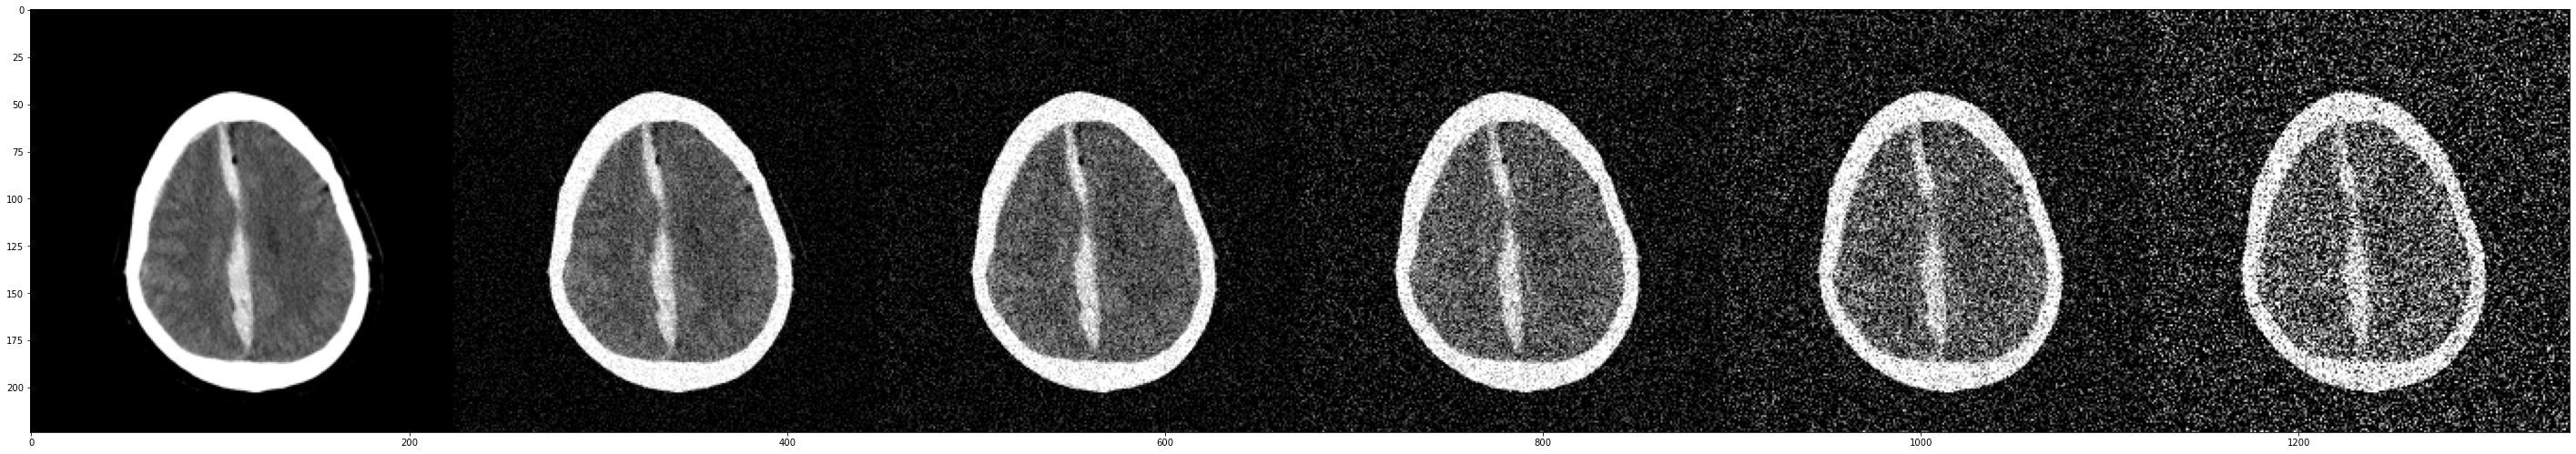

In [10]:
name = "ID_0a0afe712.png"
image0 = Image.open("test/clean/" + name)
image1 = Image.open("test/gaussian_1/" + name)
image2 = Image.open("test/gaussian_2/" + name)
image3 = Image.open("test/gaussian_3/" + name)
image4 = Image.open("test/gaussian_4/" + name)
image5 = Image.open("test/gaussian_5/" + name)

image = np.concatenate([image0, image1, image2, image3, image4, image5], axis=1)
plt.figure(figsize=(50, 50))
plt.imshow(image, cmap='gray')